In [1]:
!wget --no-check-certificate \
   https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip \
   -O /content/ISIC_2020_Training_Dicom.zip

--2023-04-17 11:03:26--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.34.153, 54.231.228.209, 54.231.137.233, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.34.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24707698022 (23G) [application/zip]
Saving to: ‘/content/ISIC_2020_Training_Dicom.zip’

/content/ISIC_2020_ 100%[===================>]  23.01G  40.1MB/s    in 9m 29s  

2023-04-17 11:12:56 (41.4 MB/s) - ‘/content/ISIC_2020_Training_Dicom.zip’ saved [24707698022/24707698022]



In [2]:
!wget --no-check-certificate \
    https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv \
    -O /content/GroundTruth.csv

--2023-04-17 11:12:56--  https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth_v2.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.201.97, 52.217.123.233, 52.217.204.1, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.201.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2387418 (2.3M) [text/csv]
Saving to: ‘/content/GroundTruth.csv’

/content/GroundTrut 100%[===================>]   2.28M  5.24MB/s    in 0.4s    

2023-04-17 11:12:57 (5.24 MB/s) - ‘/content/GroundTruth.csv’ saved [2387418/2387418]



In [3]:
pip install dicom2jpg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.4 MB/s eta 0:00:00


In [4]:
import os
import datetime
import pandas as pd
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
from tqdm import tqdm
import shutil

In [5]:
path_dataset = "./ISIC_2020_Training_Dicom.zip"

In [6]:
# Careful with activating this code block
if os.path.exists('./train'):
  shutil.rmtree('./train')
os.makedirs('./train')

from zipfile import ZipFile
file_name = path_dataset

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("extracted!")

extracted!


In [7]:
folder_path = './train/'
images_path = os.listdir(folder_path)
print('Number of files: ', len(images_path))

Number of files:  33126


In [8]:
# adapted code from kaggle to read metadata from dicom files
# https://www.kaggle.com/code/sarmat/extract-metadata-from-dicom/notebook
# def dictify(ds):
#     output = dict()
#     for elem in ds:
#         if elem.VR != 'SQ': 
#             output[elem.tag] = elem.value
#         else:
#             output[elem.tag] = [dictify(item) for item in elem]
#     return output

# metadata_train = []
# image_names_train = []
# for i in tqdm(range(len(images_path))):
#     ds1 = dcmread(folder_path+images_path[i], stop_before_pixels=True)
#     metadata_train.append(dictify(ds1))

In [9]:
#dicom2jpg.dicom2jpg('./train/ISIC_0052212.dcm', target_root='./jpg')  
# date = 10000*datetime.datetime.now().year + 100*datetime.datetime.now().month + datetime.datetime.now().day

# for i in tqdm(range(len(images_path))):
#     dicom2jpg.dicom2jpg(folder_path + images_path[i], target_root="./train/jpg")
#     for folder in os.listdir('./train/jpg/' + str(date)):
#       for subfolder in os.listdir('./train/jpg/' + str(date) + '/' + folder):
#         for file in os.listdir('./train/jpg/' + str(date) + '/' + folder + '/' + subfolder):
#           os.rename('./train/jpg/' + str(date) + '/' + folder + '/' + subfolder + '/' + file, './train/jpg/' + images_path[i][:-3] + 'jpg')
#           shutil.rmtree('./train/jpg/' + str(date) + '/' + folder)
#           os.remove('./train/' + images_path[i])

In [10]:
df = pd.read_csv('./GroundTruth.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   lesion_id                      33126 non-null  object 
 3   sex                            33061 non-null  object 
 4   age_approx                     33058 non-null  float64
 5   anatom_site_general_challenge  32599 non-null  object 
 6   diagnosis                      33126 non-null  object 
 7   benign_malignant               33126 non-null  object 
 8   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 2.3+ MB


In [11]:
# Sorting the images into malignant and benign
if not os.path.exists('./train/benign'):
  os.makedirs('./train/benign')

if not os.path.exists('./train/malignant'):
  os.makedirs('./train/malignant')

for index, row in df.iterrows():
  try:
    os.rename('./train/' + row.image_name + '.jpg', './train/' + row.benign_malignant + '/' + row.image_name + '.jpg')
  except Exception: 
    if not os.path.exists('./train/' + row.benign_malignant + '/' + row.image_name + '.jpg'):
      print(row.image_name + ', row dropped!')

In [12]:
# don't execute
for index, row in df.iterrows():
  if row.diagnosis == 'unknown' and os.path.exists('./train/' + row.benign_malignant + '/' + row.image_name + '.jpg'):
    os.remove('./train/' + row.benign_malignant + '/' + row.image_name + '.jpg')
    df = df.drop(index)

df = df.drop(df[df.diagnosis == 'unknown'].index)

# Data Visualization

In [79]:
print("Number of benign images: ", len(os.listdir('./train/benign')))
print("Number of malignant images: ", len(os.listdir('./train/malignant')))

Number of benign images:  2000
Number of malignant images:  2000


In [14]:
df.head(5)

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
12,ISIC_0076995,IP_2235340,IL_7147389,female,55.0,torso,nevus,benign,0
26,ISIC_0084086,IP_4023055,IL_9753248,male,60.0,lower extremity,nevus,benign,0
27,ISIC_0084270,IP_2961528,IL_3011969,male,40.0,lower extremity,nevus,benign,0
28,ISIC_0084395,IP_0175539,IL_8767924,female,45.0,torso,nevus,benign,0


<Axes: >

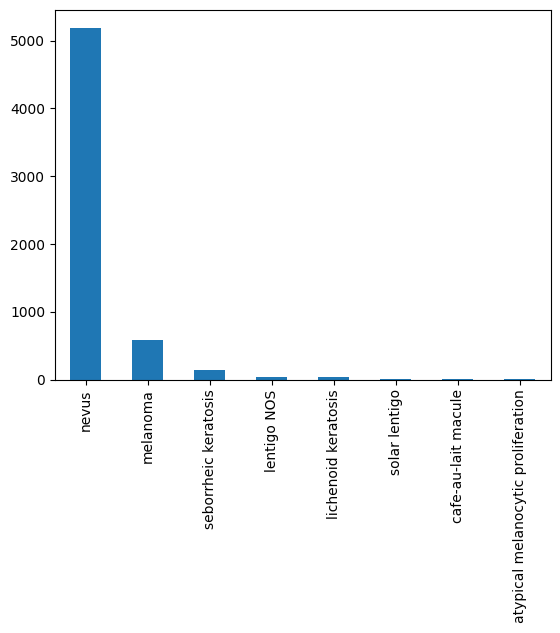

In [15]:
df['diagnosis'].value_counts().plot.bar()

<Axes: >

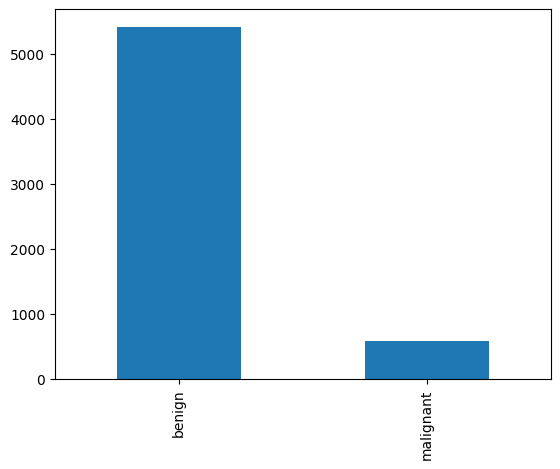

In [16]:
df['benign_malignant'].value_counts().plot.bar()

<Axes: xlabel='anatom_site_general_challenge'>

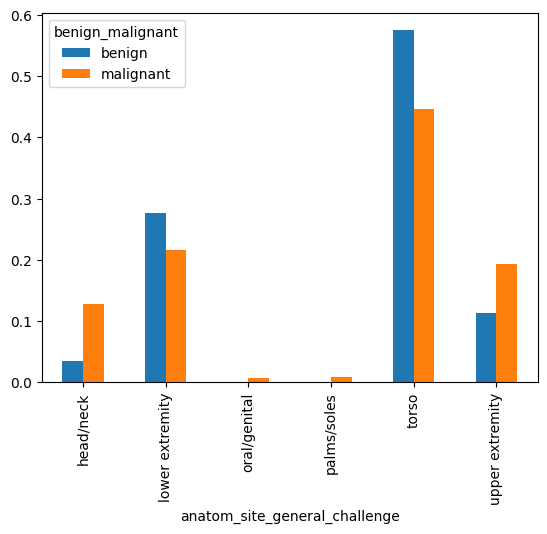

In [17]:
df.groupby(['benign_malignant'])['anatom_site_general_challenge'].value_counts(normalize=True).nlargest(11).unstack(0).plot.bar()

<Axes: xlabel='benign_malignant'>

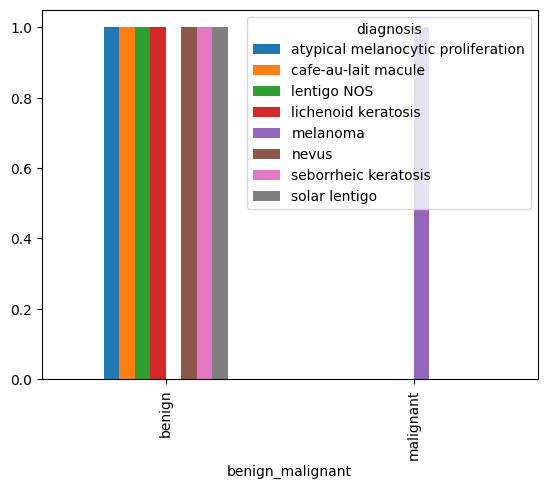

In [18]:
df.groupby(['diagnosis'])['benign_malignant'].value_counts(normalize=True).nlargest(11).unstack(0).plot.bar()

<Axes: >

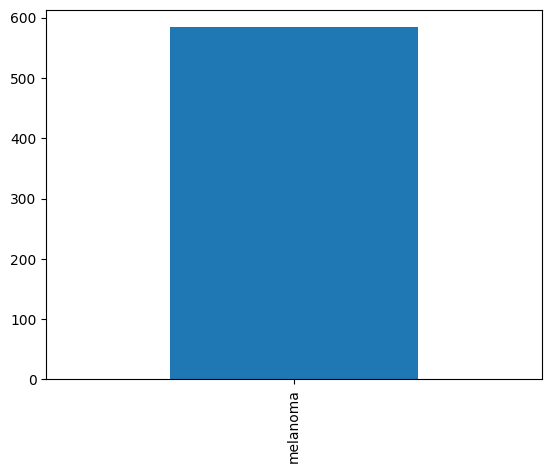

In [19]:
df[df.benign_malignant == 'malignant']['diagnosis'].value_counts().plot.bar()

# Adding more Data

In [20]:
import requests
import urllib.request

diagnose = 'melanoma'
url = 'https://api.isic-archive.com/api/v2/images/search/?query=diagnosis%3A'

# Send a GET request to the API endpoint
response = requests.get('{}%22{}%22'.format(url, diagnose))

# Parse the JSON response
json_response = response.json()

while json_response['next'] != None and json_response['next'] != 'null':
    # Loop through each result and extract the "isic_id" and "url"
    for result in json_response['results']:
        isic_id = result['isic_id']
        url = result['files']['full']['url']

        if isic_id not in df['image_name']:
            urllib.request.urlretrieve(url, './train/{}/{}.jpg'.format('malignant' if (result['metadata']['clinical']['diagnosis'] == 'melanoma') else 'benign', isic_id))
    url = json_response['next']
    response = requests.get(url)
    json_response = response.json()

# Data Augmentation

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(6000, 4000),
  batch_size=32)


val_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(6000, 4000),
  batch_size=32)

Found 11818 files belonging to 2 classes.
Using 9455 files for training.
Found 11818 files belonging to 2 classes.
Using 2363 files for validation.


In [22]:
#code from https://towardsdatascience.com/image-augmentations-in-tensorflow-62967f59239d

img_height = 350
img_width = 500

def reshape_image_dataset(dataset: tf.data.Dataset):
    dataset = dataset.map(
        lambda image, label: (tf.image.resize_with_pad(image, target_height=img_height, target_width=img_width), label))
    return dataset

train_ds = reshape_image_dataset(train_ds)

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds)

# Model Development

In [80]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

pre_trained_model = MobileNetV2(input_shape=(224,224,3),
                                include_top = False,
                                weights = 'imagenet')

for layer in pre_trained_model.layers: 
  layer.trainable = False

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

#model.load_weights('./weights.best.hdf5')

model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [ ]:
model.summary()

In [ ]:
%cd benign
%ls
%mkdir ../../stash
%mkdir ../../stash/backup_benign
%mkdir ../../stash/backup_malignant

%ls | shuf -n 4418 | xargs -i mv {} /content/stash/backup_benign/
%cd ../malignant
%ls | shuf -n 5400 | xargs -i mv {} /content/stash/backup_malignant/
%cd /content/

In [78]:
%cd stash/backup_benign/

%ls | shuf -n 1000 | xargs -i mv {} /content/train/benign/
%cd ../backup_malignant
%ls | shuf -n 1000 | xargs -i mv {} /content/train/malignant/
%cd /content/

/content/stash/backup_benign
/content/stash/backup_malignant
/content


In [81]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input
                               )

train_gen = train_idg.flow_from_directory(
    './train/',
    target_size=(224,224),
    batch_size = 64
)

checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='acc', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="acc", mode="max", patience=15)

callbacks_list = [checkpoint, early] #early

history = model.fit(train_gen, 
                              epochs=2, 
                              shuffle=True, 
                              verbose=True,
                              callbacks=callbacks_list)


Found 4000 images belonging to 2 classes.
Epoch 1/2
63/63 [==============================] - ETA: 0s - loss: 12.7142 - acc: 0.5000
Epoch 1: acc improved from -inf to 0.50000, saving model to weights.best.hdf5
63/63 [==============================] - 467s 7s/step - loss: 12.7142 - acc: 0.5000
Epoch 2/2
63/63 [==============================] - ETA: 0s - loss: 0.6935 - acc: 0.5000
Epoch 2: acc did not improve from 0.50000
63/63 [==============================] - 456s 7s/step - loss: 0.6935 - acc: 0.5000


In [27]:
from google.colab import files
try:
  files.download('./weights.best.hdf5')
except Exception:
  print()

try:
  files.download('./train/weights.best.hdf5')
except Exception:
  print()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
predicts = model.predict_generator(train_gen, verbose = True, workers = 2)

<ipython-input-82-9bda1e87d587>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicts = model.predict_generator(train_gen, verbose = True, workers = 2)


KeyboardInterrupt: ignored

In [83]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image

# Load and preprocess the input image
img_path = 'benign_test.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predict the class probabilities for the input image
preds = model.predict(x)
print(preds)

1/1 [==============================] - 1s 1s/step
[[1.]]
